In [ ]:
from datasets import load_dataset
import openai
import matplotlib.pyplot as plt
import numpy as np
import json
import os

In [ ]:
openai.api_key = os.environ['OPENAI_API_KEY']

In [3]:
coqa_dataset = load_dataset("stanfordnlp/coqa")

In [4]:
from llama_index.core import StorageContext, Document, Settings, KnowledgeGraphIndex
from llama_index.core.graph_stores import SimpleGraphStore
from llama_index.llms.openai import OpenAI

In [5]:
questions = [list(row) for row in coqa_dataset["train"].to_pandas()['questions'][:2000]]

In [6]:
answers = [list(row["input_text"]) for row in coqa_dataset["train"].to_pandas()["answers"][:2000]]

In [7]:
documents = [Document(text=row) for row in coqa_dataset["train"].to_pandas()["story"][:2000]]

In [8]:
answers[0]

['It was formally established in 1475',
 'research',
 'history, and law',
 'philosophy, science and theology',
 'a  project',
 'into periods',
 'five',
 'The Vatican Apostolic Library',
 'in Vatican City',
 '1.1 million',
 'at the beginning of the 17th century;',
 '150,000',
 'anyone who can document their qualifications and research needs.',
 'unknown',
 'Photocopies',
 'only books published between 1801 and 1990',
 'the Holy See',
 'a handful of volumes',
 'digitising manuscripts',
 'them to be viewed online.']

In [9]:
len(answers)

2000

In [10]:
questions[0]

['When was the Vat formally opened?',
 'what is the library for?',
 'for what subjects?',
 'and?',
 'what was started in 2014?',
 'how do scholars divide the library?',
 'how many?',
 'what is the official name of the Vat?',
 'where is it?',
 'how many printed books does it contain?',
 'when were the Secret Archives moved from the rest of the library?',
 'how many items are in this secret collection?',
 'Can anyone use this library?',
 'what must be requested to view?',
 'what must be requested in person or by mail?',
 'of what books?',
 'What is the Vat the library of?',
 'How many books survived the Pre Lateran period?',
 'what is the point of the project started in 2014?',
 'what will this allow?']

In [11]:
llm = OpenAI(temperature=0, model="gpt-3.5-turbo-instruct")
Settings.llm = llm
Settings.chunk_size = 512

In [12]:
from llama_index.core import StorageContext
from llama_index.graph_stores.neo4j import Neo4jGraphStore

In [13]:
username = "neo4j"
password = "password"
url = "bolt://35.229.117.88:7687"
database = "neo4j"

In [14]:
graph_store = Neo4jGraphStore(
    username=username,
    password=password,
    url=url,
    database=database,
)

In [15]:
kg_index = KnowledgeGraphIndex(
    [],
    storage_context=StorageContext.from_defaults(graph_store=graph_store),
)

In [16]:
kg_index.graph_store.get("Museum of Modern Art")

[['DATE_OF_OFFICIAL_OPENING', 'November 7, 1929'],
 ['LOCATED_IN_THE_ADMINISTRATIVE_TERRITORIAL_ENTITY', 'Manhattan'],
 ['INSTANCE_OF', 'art museum']]

In [17]:
'''with kg_index.graph_store.client as driver:
    results, summary, keys = driver.execute_query(
        "MATCH (n1)-[r]->(n2) RETURN n1, r, n2")'''

'with kg_index.graph_store.client as driver:\n    results, summary, keys = driver.execute_query(\n        "MATCH (n1)-[r]->(n2) RETURN n1, r, n2")'

In [18]:
'''kg_index.index_struct.embedding_dict = {}
def transform_string(string):
    string = string.replace("_", " ")
    return string.lower()

triplets = []
for result in results:
    triplets.append([result["n1"].get("id"), transform_string(str(type(result["r"]).__name__)), result["n2"].get("id")])

triplet_texts = [str(t) for t in triplets]

embed_outputs = kg_index._embed_model.get_text_embedding_batch(
    triplet_texts, show_progress=False
)
for rel_text, rel_embed in zip(triplet_texts, embed_outputs):
    kg_index.index_struct.add_to_embedding_dict(rel_text, rel_embed)'''

'kg_index.index_struct.embedding_dict = {}\ndef transform_string(string):\n    string = string.replace("_", " ")\n    return string.lower()\n\ntriplets = []\nfor result in results:\n    triplets.append([result["n1"].get("id"), transform_string(str(type(result["r"]).__name__)), result["n2"].get("id")])\n\ntriplet_texts = [str(t) for t in triplets]\n\nembed_outputs = kg_index._embed_model.get_text_embedding_batch(\n    triplet_texts, show_progress=False\n)\nfor rel_text, rel_embed in zip(triplet_texts, embed_outputs):\n    kg_index.index_struct.add_to_embedding_dict(rel_text, rel_embed)'

In [17]:
import json

with open('embedding_dict.json', 'r') as file:
    kg_index.index_struct.embedding_dict = json.load(file)

In [18]:
import chromadb

chroma_client = chromadb.PersistentClient()
chroma_collection = chroma_client.get_or_create_collection("quickstart")

In [19]:
from llama_index.core import VectorStoreIndex
from llama_index.vector_stores.chroma import ChromaVectorStore

In [20]:
from llama_index.core import StorageContext


vector_store = ChromaVectorStore(chroma_collection=chroma_collection)
storage_context = StorageContext.from_defaults(vector_store=vector_store)

In [21]:
#documents = [Document(text=doc) for doc in coqa_dataset["train"].to_pandas()['story']]
#index = VectorStoreIndex(documents, storage_context=storage_context)

index = VectorStoreIndex.from_vector_store(vector_store)

In [22]:
from query_engine import RAGStringQueryEngine, RAGCachedStringQueryEngine

In [23]:
query_engine = index.as_query_engine(
    similarity_top_k=5
)

In [24]:
from tqdm.notebook import tqdm

for i in tqdm(range(2)):
    for j in range(len(questions[i])):
        print("RESPONSE: " + str(query_engine.query(questions[i][j])))
        print("ANSWER: " + answers[i][j] + "\n")


  0%|          | 0/2 [00:00<?, ?it/s]

RESPONSE: 
The context information does not mention anything about a Vat being formally opened. Therefore, there is no answer to this query.
ANSWER: It was formally established in 1475

RESPONSE: 
The Vatican Library is a research library for history, law, philosophy, science and theology.
ANSWER: research

RESPONSE: 
The subjects mentioned in the context information are mathematics, English, Chinese, and possibly other languages.
ANSWER: history, and law

RESPONSE: 
"And" is a conjunction used to connect words, phrases, or clauses in a sentence. It can also be used to indicate addition, contrast, or continuation. In the given context, "and" is used to connect two clauses and continue the description of the scene.
ANSWER: philosophy, science and theology

RESPONSE: The 2014 World Cup qualifying group in South America was started in 2014.
ANSWER: a  project

RESPONSE: 
Scholars have traditionally divided the history of the library into five periods, Pre-Lateran, Lateran, Avignon, Pre-Va

In [21]:
#engine = RAGStringQueryEngine(llm, kg_index, index, 3, 5, 5)

In [22]:
#engine.custom_query(questions[0][0])

In [25]:
from llama_index.core.graph_stores import SimpleGraphStore

from tqdm.notebook import tqdm

for i in tqdm(range(2)):
    print("BUILDING KNOWLEDGE GRAPH")
    temp_graph_store = SimpleGraphStore()
    temp_kg_index = KnowledgeGraphIndex.from_documents(
        [documents[i]],
        max_triplets_per_chunk=100,
        storage_context=storage_context,
        show_progress=True,
        include_embeddings=True,
    )

    engine = RAGStringQueryEngine(llm, temp_kg_index, index, 3, 5, 5)
    for j in range(len(questions[i])):
        print("RESPONSE: " + str(engine.custom_query(questions[i][j])))
        print("ANSWER: " + answers[i][j] + "\n")

  0%|          | 0/2 [00:00<?, ?it/s]

BUILDING KNOWLEDGE GRAPH


Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/184 [00:00<?, ?it/s]

RESPONSE: 1475
ANSWER: It was formally established in 1475

RESPONSE: The Vatican Library is a research library for history, law, philosophy, science and theology.
ANSWER: research

RESPONSE: 
The subjects covered in the Encyclopædia Britannica include general knowledge, English-language, history, science, literature, and various other topics.
ANSWER: history, and law

RESPONSE: 
I'm not sure what you are asking for. Can you please provide more context or clarify your question?
ANSWER: philosophy, science and theology

RESPONSE: 
The Vatican Library's project of digitising its collection of manuscripts.
ANSWER: a  project

RESPONSE: 
Scholars traditionally divide the history of the library into five periods: Pre-Lateran, Lateran, Avignon, Pre-Vatican, and Vatican.
ANSWER: into periods

RESPONSE: 1 million historic documents
ANSWER: five

RESPONSE: The official name of the Vatican Apostolic Library is the Vatican Library.
ANSWER: The Vatican Apostolic Library

RESPONSE: 
It is not speci

Parsing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Processing nodes:   0%|          | 0/1 [00:00<?, ?it/s]

Generating embeddings:   0%|          | 0/23 [00:00<?, ?it/s]

RESPONSE: The auction was held at the Hard Rock Cafe in New York's Times Square.
ANSWER: Hard Rock Cafe

RESPONSE: The auction at the Hard Rock Cafe in New York's Times Square reaped a total of $2 million in sales.
ANSWER: $2 million.

RESPONSE: They expected $120,000 in sales.
ANSWER: $120,000

RESPONSE:  Hoffman Ma, who bought the glove on behalf of Ponte 16 Resort in Macau.
ANSWER: Hoffman Ma

RESPONSE: The buyer of the glove was from Hong Kong, China.
ANSWER: Macau



In [27]:
print(questions[0])
print(questions[1])

['When was the Vat formally opened?', 'what is the library for?', 'for what subjects?', 'and?', 'what was started in 2014?', 'how do scholars divide the library?', 'how many?', 'what is the official name of the Vat?', 'where is it?', 'how many printed books does it contain?', 'when were the Secret Archives moved from the rest of the library?', 'how many items are in this secret collection?', 'Can anyone use this library?', 'what must be requested to view?', 'what must be requested in person or by mail?', 'of what books?', 'What is the Vat the library of?', 'How many books survived the Pre Lateran period?', 'what is the point of the project started in 2014?', 'what will this allow?']
['Where was the Auction held?', 'How much did they make?', 'How much did they expected?', 'WHo buy the Jackson Glove', 'Where was the buyer of the glove from?']


In [26]:
temp_kg_index.index_struct.embedding_dict.keys()

dict_keys(["('Vatican apostolic library', 'Is called', 'Vatican library')", "('Vatican apostolic library', 'Is located in', 'Vatican city')", "('Vatican apostolic library', 'Was established in', '1475')", "('Vatican apostolic library', 'Contains', 'Significant collections')", "('Vatican apostolic library', 'Has', '1.1 million printed books')", "('Vatican apostolic library', 'Is', 'Research library')", "('Vatican apostolic library', 'Is open to', 'Anyone')", "('Vatican apostolic library', 'Can be requested', 'Photocopies')", "('Vatican apostolic library', 'Began', 'Digitising')", "('Vatican apostolic library', 'Contains', 'Vatican secret archives')", "('Vatican apostolic library', 'Was separated from', 'Library')", "('Vatican apostolic library', 'Have divided', 'History')", "('Vatican apostolic library', 'Divided into', 'Five periods')", "('Vatican apostolic library', 'Comprises', 'Pre-lateran period')", "('Vatican apostolic library', 'Dated from', 'Earliest days')", "('Vatican apostoli

In [24]:
'''engine.time_profile'''

'engine.time_profile'

In [25]:
'''num_retrieved = [profile["NUM TOTAL DOCUMENTS"] for profile in engine.time_profile]
node_retrieval = [profile["NODE RETRIEVAL"] for profile in engine.time_profile]
node_traversal = [profile["NODE TRAVERSAL"] for profile in engine.time_profile]
doc_retrieval = [profile["DOCUMENT RETRIEVAL"] for profile in engine.time_profile]

#plt.hist(num_retrieved, bins=30)
plt.scatter(num_retrieved, node_retrieval, c='r')
#plt.scatter(num_retrieved, node_traversal, c='g')
plt.scatter(num_retrieved, doc_retrieval, c='b')
plt.show()'''

'num_retrieved = [profile["NUM TOTAL DOCUMENTS"] for profile in engine.time_profile]\nnode_retrieval = [profile["NODE RETRIEVAL"] for profile in engine.time_profile]\nnode_traversal = [profile["NODE TRAVERSAL"] for profile in engine.time_profile]\ndoc_retrieval = [profile["DOCUMENT RETRIEVAL"] for profile in engine.time_profile]\n\n#plt.hist(num_retrieved, bins=30)\nplt.scatter(num_retrieved, node_retrieval, c=\'r\')\n#plt.scatter(num_retrieved, node_traversal, c=\'g\')\nplt.scatter(num_retrieved, doc_retrieval, c=\'b\')\nplt.show()'

In [28]:
engine = RAGCachedStringQueryEngine(llm, kg_index, index, 3, 5, 5)

from tqdm.notebook import tqdm

for i in tqdm(range(200)):
    engine.custom_query(questions[i][0])

  0%|          | 0/200 [00:00<?, ?it/s]

Retrying llama_index.llms.openai.base.OpenAI._complete in 0.9719844704643349 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo-instruct in organization org-FOiSJSgty59EEdVG6ekXzH6l on tokens per min (TPM): Limit 90000, Used 89664, Requested 3789. Please try again in 2.302s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}.
Retrying llama_index.llms.openai.base.OpenAI._complete in 0.4260553888460632 seconds as it raised RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-3.5-turbo-instruct in organization org-FOiSJSgty59EEdVG6ekXzH6l on tokens per min (TPM): Limit 90000, Used 89660, Requested 3789. Please try again in 2.299s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}.
Retrying llama_index.llms.openai.base.OpenAI._

In [29]:
engine.time_profile

[{'NODE RETRIEVAL': 2.551743984222412,
  'NODE TRAVERSAL': 0.0,
  'DOCUMENT RETRIEVAL': 0.0,
  'READ FROM CACHE': 0.005598306655883789,
  'CACHE RETRIEVAL': 0.007591724395751953,
  'WRITE TO CACHE': 0.0,
  'NUM TOTAL DOCUMENTS': 90},
 {'NODE RETRIEVAL': 2.0745961666107178,
  'NODE TRAVERSAL': 0.0,
  'DOCUMENT RETRIEVAL': 0.0,
  'READ FROM CACHE': 0.009440898895263672,
  'CACHE RETRIEVAL': 0.04606437683105469,
  'WRITE TO CACHE': 0.0,
  'NUM TOTAL DOCUMENTS': 851},
 {'NODE RETRIEVAL': 2.4628992080688477,
  'NODE TRAVERSAL': 0.41254615783691406,
  'DOCUMENT RETRIEVAL': 2.734778642654419,
  'READ FROM CACHE': 0.004494667053222656,
  'CACHE RETRIEVAL': 0.014463663101196289,
  'WRITE TO CACHE': 0.008331537246704102,
  'NUM TOTAL DOCUMENTS': 915},
 {'NODE RETRIEVAL': 2.2483298778533936,
  'NODE TRAVERSAL': 0.5857956409454346,
  'DOCUMENT RETRIEVAL': 2.3860254287719727,
  'READ FROM CACHE': 0.002363920211791992,
  'CACHE RETRIEVAL': 0.0007188320159912109,
  'WRITE TO CACHE': 0.042572736740112

In [32]:
engine.cache.redis_cache.flushdb()

True

In [18]:
cache_sizes = ["0", "357k", "1785k", "3213k", "4641k", "6069k"]
hits = []
hit_rate = []

for c in cache_sizes:
    file_path = f"data/cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_cache_size={c}_redis.json"
    with open(file_path, 'r') as file:
        data = json.load(file)
        hits.append(data["keyspace_hits"])
        hit_rate.append(data["hit_rate"])

print("Hits: ", hits)
print("Hit Rate: ", hit_rate)

Hits:  [2156, 0, 1654, 2125, 2156, 2156]
Hit Rate:  [0.5403508771929825, 0.0, 0.4145363408521303, 0.5325814536340853, 0.5403508771929825, 0.5403508771929825]


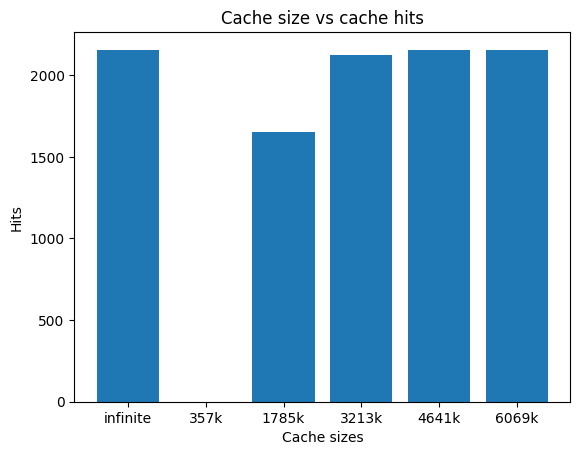

In [19]:
cache_sizes[0] = "infinite"
plt.bar(cache_sizes, hits)

# Add labels and title
plt.xlabel('Cache sizes')
plt.ylabel('Hits')
plt.title('Cache size vs cache hits')

# Show the plot
plt.show()

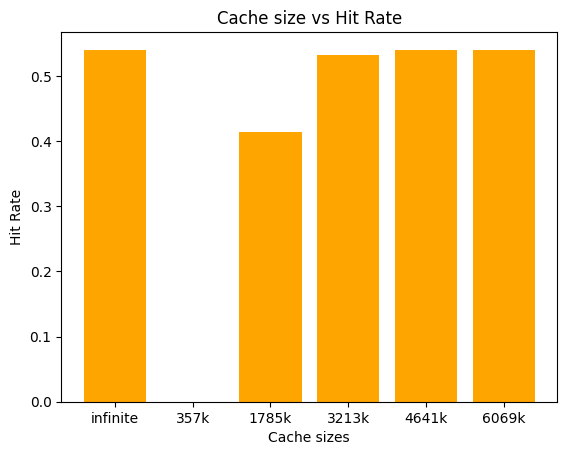

In [20]:
cache_sizes[0] = "infinite"
plt.bar(cache_sizes, hit_rate, color="orange")

# Add labels and title
plt.xlabel('Cache sizes')
plt.ylabel('Hit Rate')
plt.title('Cache size vs Hit Rate')

# Show the plot
plt.show()

In [21]:
cache_sizes = ["", "0", "357k", "1785k", "3213k", "4641k", "6069k"]
time_profile = [[], [], [], [], [], [], []]

for c in cache_sizes:
    file_path = "data/wikipedia_traverse_k=3_retrieve_k=5_return_n=5_time_profile.json"
    if c != "":
        file_path = f"data/cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_cache_size={c}_time_profile.json"
    with open(file_path, 'r') as file:
        data = json.load(file)
        temp = {"NODE RETRIEVAL": 0.0, "NODE TRAVERSAL": 0.0, "DOCUMENT RETRIEVAL": 0.0, "NUM TOTAL DOCUMENTS": 0.0}
        for i in range(len(data)):
            # print(data[i])
            temp["NODE RETRIEVAL"] += data[i]["NODE RETRIEVAL"]
            temp["DOCUMENT RETRIEVAL"] += data[i]["DOCUMENT RETRIEVAL"]
            temp["NODE TRAVERSAL"] += data[i]["NODE TRAVERSAL"]
            temp["NUM TOTAL DOCUMENTS"] += data[i]["NUM TOTAL DOCUMENTS"]

        temp["NODE RETRIEVAL"] = temp["NODE RETRIEVAL"] / len(data)
        time_profile[0].append(temp["NODE RETRIEVAL"] / len(data))

        temp["DOCUMENT RETRIEVAL"] = temp["DOCUMENT RETRIEVAL"] / len(data)
        time_profile[1].append(temp["DOCUMENT RETRIEVAL"] / len(data))

        temp["NODE TRAVERSAL"] = temp["NODE TRAVERSAL"] / len(data)
        time_profile[2].append(temp["NODE TRAVERSAL"] / len(data))

        temp["NUM TOTAL DOCUMENTS"] = temp["NUM TOTAL DOCUMENTS"] / len(data)
        time_profile[3].append(temp["NUM TOTAL DOCUMENTS"] / len(data))
        print(file_path)
        # time_profile.append(temp)

print(time_profile)

data/wikipedia_traverse_k=3_retrieve_k=5_return_n=5_time_profile.json
data/cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_cache_size=0_time_profile.json
data/cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_cache_size=357k_time_profile.json
data/cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_cache_size=1785k_time_profile.json
data/cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_cache_size=3213k_time_profile.json
data/cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_cache_size=4641k_time_profile.json
data/cache_wikipedia_traverse_k=3_retrieve_k=5_return_n=5_cache_size=6069k_time_profile.json
[[0.0043242802023887635, 0.004418990340828896, 0.0042125369176268575, 0.004210818827152252, 0.00410780973136425, 0.0040979193523526195, 0.0041303887814283366], [0.0004575781315565109, 0.00018174140751361847, 0.0004398010075092316, 0.00022266525328159333, 0.00016886364966630936, 0.000165324766933918, 0.0001607226625084877], [0.000646360570192337, 0.00034499749541282653, 0.000

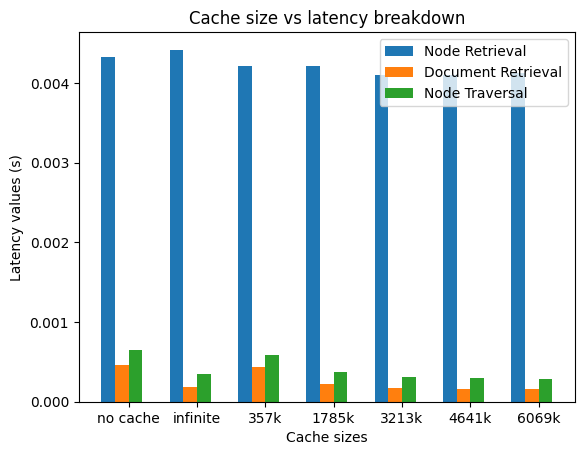

In [23]:
cache_sizes[0] = "no cache"
cache_sizes[1] = "infinite"
bar_width = 0.2

# Set the x locations for the groups
x = np.arange(len(cache_sizes))

# Create multi-bar chart
plt.bar(x - 1.5 * bar_width, time_profile[0], width=bar_width, label='Node Retrieval')
plt.bar(x - 0.5 * bar_width, time_profile[1], width=bar_width, label='Document Retrieval')
plt.bar(x + 0.5 * bar_width, time_profile[2], width=bar_width, label='Node Traversal')
#plt.bar(x + 1.5 * bar_width, time_profile[3], width=bar_width, label='Group 4')

# Add labels and title
plt.xlabel('Cache sizes')
plt.ylabel('Latency values (s)')
plt.title('Cache size vs latency breakdown')
plt.xticks(x, cache_sizes)
plt.legend()

# Show the plot
plt.show()

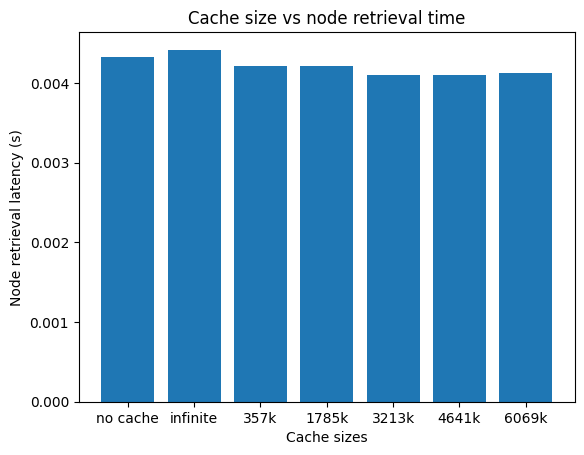

In [24]:
plt.bar(cache_sizes, time_profile[0])

# Add labels and title
plt.xlabel('Cache sizes')
plt.ylabel('Node retrieval latency (s)')
plt.title('Cache size vs node retrieval time')

# Show the plot
plt.show()

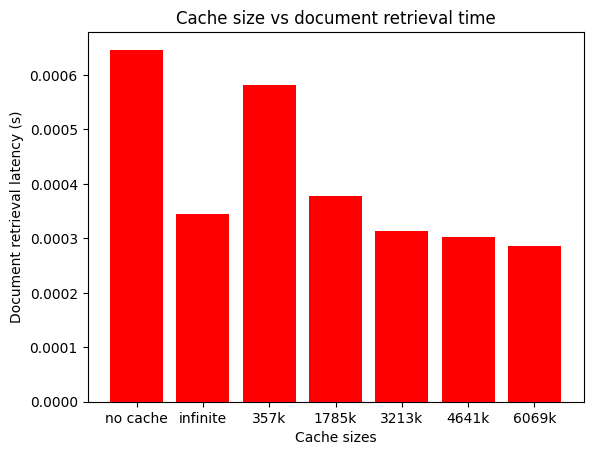

In [28]:
plt.bar(cache_sizes, time_profile[2], color="red")

# Add labels and title
plt.xlabel('Cache sizes')
plt.ylabel('Document retrieval latency (s)')
plt.title('Cache size vs document retrieval time')

# Show the plot
plt.show()

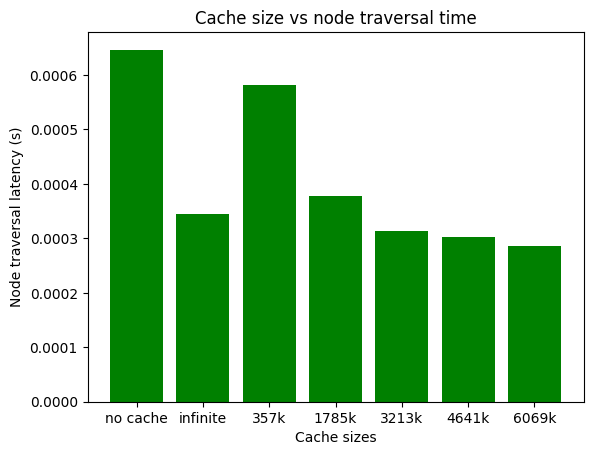

In [27]:
plt.bar(cache_sizes, time_profile[2], color="green")

# Add labels and title
plt.xlabel('Cache sizes')
plt.ylabel('Node traversal latency (s)')
plt.title('Cache size vs node traversal time')

# Show the plot
plt.show()

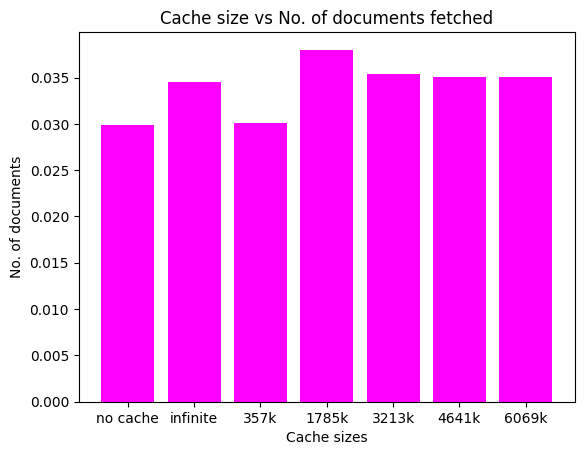

In [31]:
plt.bar(cache_sizes, time_profile[3], color="magenta")

# Add labels and title
plt.xlabel('Cache sizes')
plt.ylabel('No. of documents')
plt.title('Cache size vs No. of documents fetched')

# Show the plot
plt.show()

In [33]:
depth = [1, 2, 3]
no_cache_time_profile = [[], [], [], []]
cache_time_profile = [[], [], [], []]

for d in depth:
    no_cache_file_path = f"data/wikipedia_traverse_k={d}_retrieve_k=5_return_n=5_time_profile.json"
    file_path = f"data/cache_wikipedia_traverse_k={d}_retrieve_k=5_return_n=5_cache_size=0_time_profile.json"
    with open(no_cache_file_path, 'r') as file:
        data = json.load(file)
        temp = {"NODE RETRIEVAL": 0.0, "NODE TRAVERSAL": 0.0, "DOCUMENT RETRIEVAL": 0.0, "NUM TOTAL DOCUMENTS": 0.0}
        for i in range(len(data)):
            # print(data[i])
            temp["NODE RETRIEVAL"] += data[i]["NODE RETRIEVAL"]
            temp["DOCUMENT RETRIEVAL"] += data[i]["DOCUMENT RETRIEVAL"]
            temp["NODE TRAVERSAL"] += data[i]["NODE TRAVERSAL"]
            temp["NUM TOTAL DOCUMENTS"] += data[i]["NUM TOTAL DOCUMENTS"]

        temp["NODE RETRIEVAL"] = temp["NODE RETRIEVAL"] / len(data)
        no_cache_time_profile[0].append(temp["NODE RETRIEVAL"] / len(data))

        temp["DOCUMENT RETRIEVAL"] = temp["DOCUMENT RETRIEVAL"] / len(data)
        no_cache_time_profile[1].append(temp["DOCUMENT RETRIEVAL"] / len(data))

        temp["NODE TRAVERSAL"] = temp["NODE TRAVERSAL"] / len(data)
        no_cache_time_profile[2].append(temp["NODE TRAVERSAL"] / len(data))

        temp["NUM TOTAL DOCUMENTS"] = temp["NUM TOTAL DOCUMENTS"] / len(data)
        no_cache_time_profile[3].append(temp["NUM TOTAL DOCUMENTS"] / len(data))

    with open(file_path, 'r') as file:
        data = json.load(file)
        temp = {"NODE RETRIEVAL": 0.0, "NODE TRAVERSAL": 0.0, "DOCUMENT RETRIEVAL": 0.0, "NUM TOTAL DOCUMENTS": 0.0}
        for i in range(len(data)):
            # print(data[i])
            temp["NODE RETRIEVAL"] += data[i]["NODE RETRIEVAL"]
            temp["DOCUMENT RETRIEVAL"] += data[i]["DOCUMENT RETRIEVAL"]
            temp["NODE TRAVERSAL"] += data[i]["NODE TRAVERSAL"]
            temp["NUM TOTAL DOCUMENTS"] += data[i]["NUM TOTAL DOCUMENTS"]

        temp["NODE RETRIEVAL"] = temp["NODE RETRIEVAL"] / len(data)
        cache_time_profile[0].append(temp["NODE RETRIEVAL"] / len(data))

        temp["DOCUMENT RETRIEVAL"] = temp["DOCUMENT RETRIEVAL"] / len(data)
        cache_time_profile[1].append(temp["DOCUMENT RETRIEVAL"] / len(data))

        temp["NODE TRAVERSAL"] = temp["NODE TRAVERSAL"] / len(data)
        cache_time_profile[2].append(temp["NODE TRAVERSAL"] / len(data))

        temp["NUM TOTAL DOCUMENTS"] = temp["NUM TOTAL DOCUMENTS"] / len(data)
        cache_time_profile[3].append(temp["NUM TOTAL DOCUMENTS"] / len(data))

print(no_cache_file_path)
print(cache_time_profile)

data/wikipedia_traverse_k=3_retrieve_k=5_return_n=5_time_profile.json
[[0.004510245934128762, 0.0045352366954088215, 0.004418990340828896], [0.00010764134973287582, 0.00015297081172466277, 0.00018174140751361847], [0.00033029008209705356, 0.0003528259411454201, 0.00034499749541282653], [0.0239, 0.03086875, 0.03455625]]


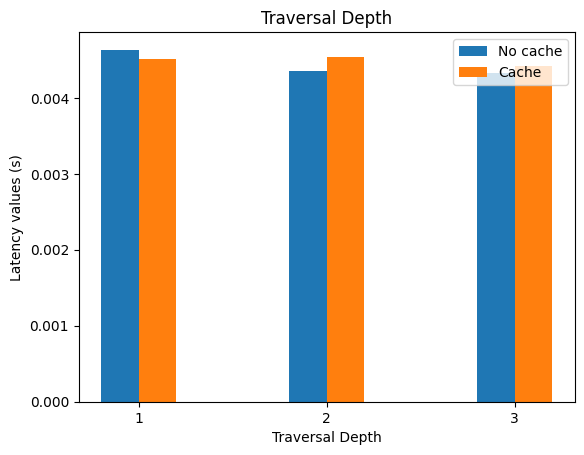

In [37]:
bar_width = 0.2

# Set the x locations for the groups
x = np.arange(len(depth))

# Create multi-bar chart
# plt.bar(x - 1.5 * bar_width, time_profile[0], width=bar_width, label='Node Retrieval')
plt.bar(x - 0.5 * bar_width, no_cache_time_profile[0], width=bar_width, label='No cache')
plt.bar(x + 0.5 * bar_width, cache_time_profile[0], width=bar_width, label='Cache')
#plt.bar(x + 1.5 * bar_width, time_profile[3], width=bar_width, label='Group 4')

# Add labels and title
plt.xlabel('Traversal Depth')
plt.ylabel('Latency values (s)')
plt.title('Traversal Depth vs Node Retrieval Time')
plt.xticks(x, depth)
plt.legend()

# Show the plot
plt.show()

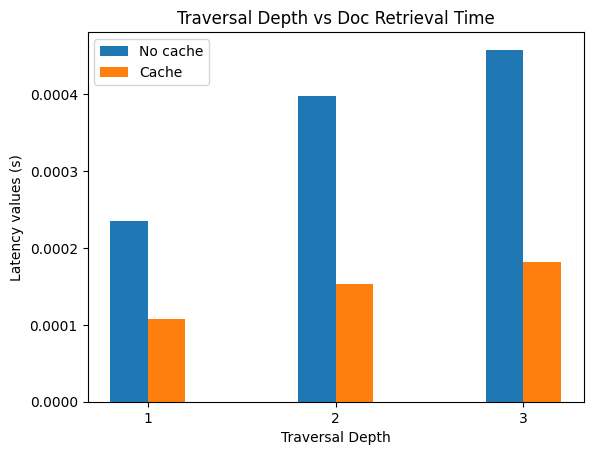

In [38]:
bar_width = 0.2

# Set the x locations for the groups
x = np.arange(len(depth))

# Create multi-bar chart
# plt.bar(x - 1.5 * bar_width, time_profile[0], width=bar_width, label='Node Retrieval')
plt.bar(x - 0.5 * bar_width, no_cache_time_profile[1], width=bar_width, label='No cache')
plt.bar(x + 0.5 * bar_width, cache_time_profile[1], width=bar_width, label='Cache')
#plt.bar(x + 1.5 * bar_width, time_profile[3], width=bar_width, label='Group 4')

# Add labels and title
plt.xlabel('Traversal Depth')
plt.ylabel('Latency values (s)')
plt.title('Traversal Depth vs Doc Retrieval Time')
plt.xticks(x, depth)
plt.legend()

# Show the plot
plt.show()

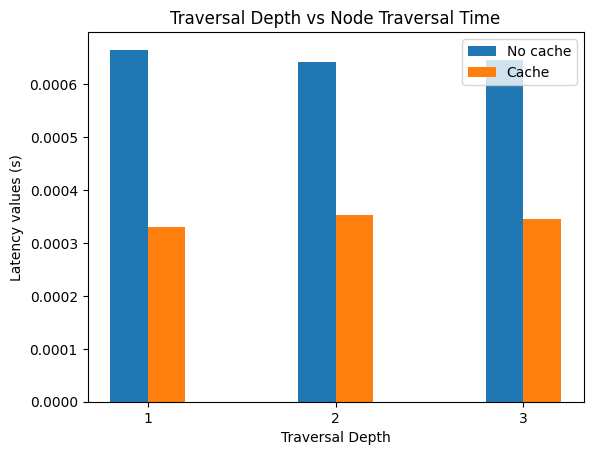

In [39]:
bar_width = 0.2

# Set the x locations for the groups
x = np.arange(len(depth))

# Create multi-bar chart
# plt.bar(x - 1.5 * bar_width, time_profile[0], width=bar_width, label='Node Retrieval')
plt.bar(x - 0.5 * bar_width, no_cache_time_profile[2], width=bar_width, label='No cache')
plt.bar(x + 0.5 * bar_width, cache_time_profile[2], width=bar_width, label='Cache')
#plt.bar(x + 1.5 * bar_width, time_profile[3], width=bar_width, label='Group 4')

# Add labels and title
plt.xlabel('Traversal Depth')
plt.ylabel('Latency values (s)')
plt.title('Traversal Depth vs Node Traversal Time')
plt.xticks(x, depth)
plt.legend()

# Show the plot
plt.show()

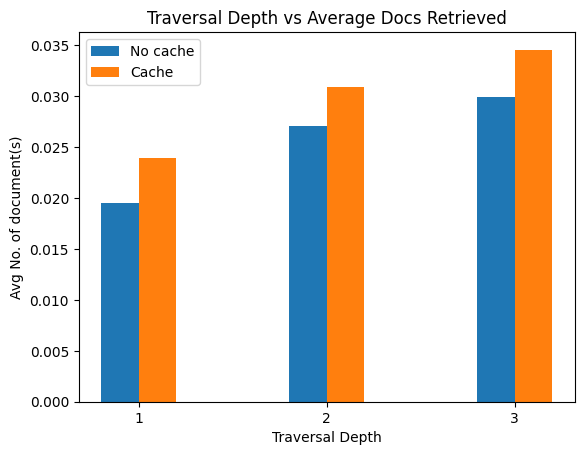

In [41]:
bar_width = 0.2

# Set the x locations for the groups
x = np.arange(len(depth))

# Create multi-bar chart
# plt.bar(x - 1.5 * bar_width, time_profile[0], width=bar_width, label='Node Retrieval')
plt.bar(x - 0.5 * bar_width, no_cache_time_profile[3], width=bar_width, label='No cache')
plt.bar(x + 0.5 * bar_width, cache_time_profile[3], width=bar_width, label='Cache')
#plt.bar(x + 1.5 * bar_width, time_profile[3], width=bar_width, label='Group 4')

# Add labels and title
plt.xlabel('Traversal Depth')
plt.ylabel('Avg No. of document(s)')
plt.title('Traversal Depth vs Average Docs Retrieved')
plt.xticks(x, depth)
plt.legend()

# Show the plot
plt.show()

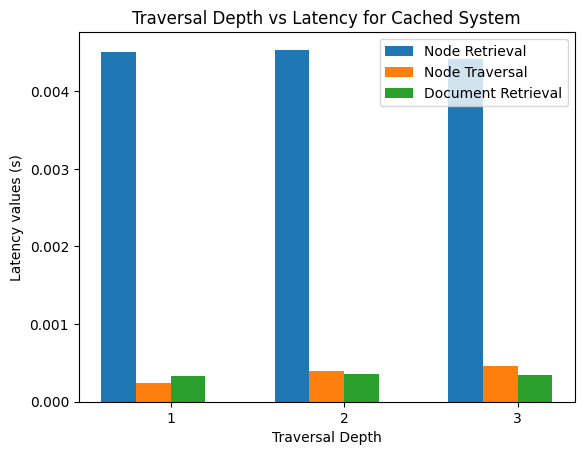

In [46]:
bar_width = 0.2

# Set the x locations for the groups
x = np.arange(len(depth))

# Create multi-bar chart
plt.bar(x - 1.5 * bar_width, cache_time_profile[0], width=bar_width, label='Node Retrieval')
plt.bar(x - 0.5 * bar_width, no_cache_time_profile[1], width=bar_width, label='Node Traversal')
plt.bar(x + 0.5 * bar_width, cache_time_profile[2], width=bar_width, label='Document Retrieval')
#plt.bar(x + 1.5 * bar_width, time_profile[3], width=bar_width, label='Group 4')

# Add labels and title
plt.xlabel('Traversal Depth')
plt.ylabel('Latency values (s)')
plt.title('Traversal Depth vs Latency for Cached System')
plt.xticks(x, depth)
plt.legend()

# Show the plot
plt.show()